In [73]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

import os
from tqdm import tqdm
import pickle

import torch
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

## Exploratory Data Analysis

we have four classes: no_tumor, pituitary tumor, menigioma tumor, and glioma tumor

In [4]:
parent_dir = os.path.dirname(os.getcwd())
training_data_dir = os.path.join(parent_dir, "input/brain-tumor-classification-mri/Training")

for item in os.listdir(training_data_dir):
    print(item)

no_tumor
pituitary_tumor
meningioma_tumor
glioma_tumor


images with tumor classes have roughly the same number. images with no_tumor is about one half compared to other classes. there might be an overfitting problem later on.

395
827
822
826


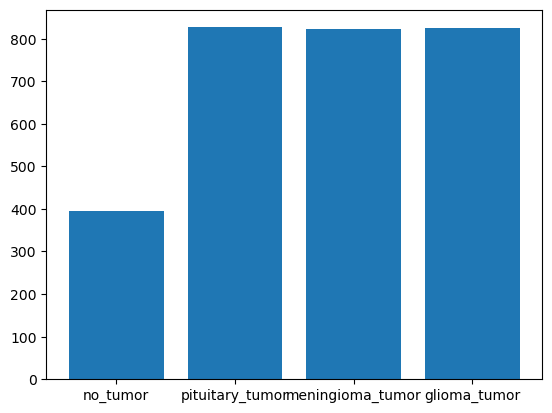

In [5]:
class_folder_paths = [os.path.join(training_data_dir, loc) for loc in list(os.listdir(training_data_dir))]
no_t, p_t, m_t, g_t = class_folders = [os.listdir(class_path) for class_path in class_folder_paths]



print(len(no_t))
print(len(p_t))
print(len(m_t))
print(len(g_t))


plt.bar(os.listdir(training_data_dir), [len(class_) for class_ in [no_t, p_t, m_t, g_t]])
plt.show()

we visualize how images from each class might look like. Each row represents one class.

In [6]:
# pick a random image and visualize them
choices = np.random.randint(0, 394, (4, 5))

fig = plt.figure(figsize=(25, 20))
for class_ in range(0, 4):
    for sample_idx in range(0, 5):
        index = choices[class_, sample_idx]
        ax = fig.add_subplot(4, 5, class_*5+sample_idx+1)
        
        image_data = mpimg.imread(os.path.join(class_folder_paths[class_],class_folders[class_][sample_idx]))
        ax.imshow(image_data)

fig.show()

NameError: name 'sample_id' is not defined

<Figure size 2500x2000 with 0 Axes>

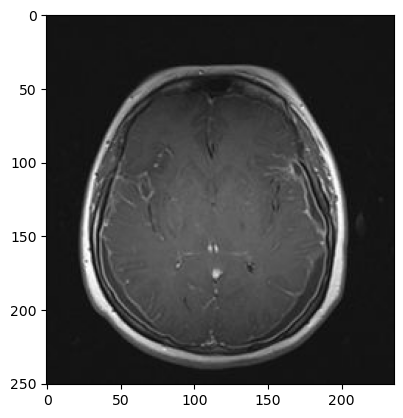

In [7]:
plt.imshow(mpimg.imread(os.path.join(class_folder_paths[0],class_folders[0][10])))

We will compute the mean and standard deviation of pixel values for normalizing (standardizing) our images.

In [97]:
def calculate_mean_and_sd_of_images():

    dataset = torchvision.datasets.ImageFolder(os.path.join(os.getcwd(), "../input/brain-tumor-classification-mri/Training"),
                                               transform=transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()]))
    subset_size = 1000
    subset_indices = np.random.choice(len(dataset), subset_size, replace=False)
    subset = torch.utils.data.Subset(dataset, subset_indices)
    batch_size = 128
    dataloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False)

    sum_    = torch.tensor([0.0, 0.0, 0.0])
    sum_sq = torch.tensor([0.0, 0.0, 0.0])

    
    for image_tensors, _ in tqdm(dataloader):
        sum_    += image_tensors.sum(axis = [0, 2, 3])
        sum_sq += (image_tensors**2).sum(axis = [0, 2, 3])

    count = subset_size * 256 * 256

    # mean and std
    total_mean = sum_ / count
    total_var  = (sum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)
    return total_mean, total_sd

In [96]:
total_mean, total_std = calculate_mean_and_sd_of_images()
print(total_mean)
print(total_std)

tensor([0.1720, 0.1720, 0.1720])
tensor([0.1924, 0.1924, 0.1924])


It seems like these are grey-scale images with varying sizes.

## Baseline Model Training

In [182]:
def custom_train_valid_split(labels, seed=123, dryrun=False, is_train=True):
    # y must be ndarray
    x = np.arange(len(labels))
    
    if dryrun:
        sss = StratifiedShuffleSplit(n_splits=2, train_size=15, test_size=5, random_state=seed)
        train_indices, test_indices = next(sss.split(x, labels))
    else:
        sss = StratifiedShuffleSplit(n_splits=2, train_size=0.8, random_state=seed)
        train_indices, test_indices = next(sss.split(x, labels))
    
    return train_indices, test_indices

def get_transformer():
    # definining transformers
    return transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.1720, 0.1720, 0.1720], [0.1924, 0.1924, 0.1924])])

def create_train_valid_data_loaders(batch_size, dryrun=False, get_transformer=get_transformer):
    
    # loading data
    dataset = torchvision.datasets.ImageFolder(os.path.join(os.getcwd(), "../input/brain-tumor-classification-mri/Training"),
                                              transform=get_transformer())
    
    # splitting into train and valid dataset
    labels = dataset.targets
    train_indices, valid_indices = custom_train_valid_split(labels, dryrun=dryrun)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    valid_dataset = torch.utils.data.Subset(dataset, valid_indices)
    
    # creating data loader
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=not dryrun)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
    
    return train_loader, valid_loader

In [52]:
def calculate_cm(y, pred):
    indices = np.ravel_multi_index((y, pred), (4, 4))
    bin_counts = np.bincount(indices, minlength=4*4)
    return bin_counts.reshape(4, 4)

In [54]:
def train_1epoch(model, data_loader, optimizer, loss_func, device=None):
    total_acc, total_loss = 0, 0
    cm = np.zeros((4,4))
    
    model.train()
    for X, y in tqdm(data_loader):
        if device:
            X = X.to(device)
            y = y.to(device)
        
        optimizer.zero_grad()
        out = model(X)
        loss = loss_func(out, y)
        _, pred = torch.max(out.detach(), 1)  # returns (max vals, argmax); don't forget to deatch - it's not part of model
        loss.backward()
        optimizer.step()
        
        # calculating metrics
        total_loss += loss.item() * X.size(0)
        total_acc += torch.sum(pred == y)
        
        cm += calculate_cm(y.cpu().numpy(), pred.cpu().numpy())
    
    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_acc / len(train_loader.dataset)
    
    return avg_loss, avg_acc, cm

In [55]:
def valid_1epoch(model, valid_loader, loss_func, device=None):
    total_acc, total_loss = 0, 0
    cm = np.zeros((4,4))
    
    model.eval()
    
    with torch.no_grad():
        for X, y in tqdm(valid_loader):
            if device:
                X = X.to(device)
                y = y.to(device)
                
            out = model(X)
            loss = loss_func(out.detach(), y)
            _, pred = torch.max(out, 1)

            total_loss += loss.item() * X.size(0)
            total_acc += torch.sum(y == pred)
            
            cm += calculate_cm(y.cpu().numpy(), pred.cpu().numpy())
            
    
    avg_loss = total_loss / len(valid_loader.dataset)
    avg_acc = total_acc / len(valid_loader.dataset)
    
    return avg_loss, avg_acc, cm

Now we use above functions to train our baseline model.

In [176]:
# for training
# create a model
device = "cuda:0"
dryrun = False

model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes
model.to(device)

# default settings: CE as loss function and SGD with lr=0.01 and momentum=0.9
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
train_accs, train_losses, valid_accs, valid_losses = [], [], [], []
train_tot_cm, valid_tot_cm = np.zeros((4,4)), np.zeros((4,4))

batch_size = 64
train_loader, valid_loader = create_train_valid_data_loaders(batch_size, dryrun=dryrun)

for epoch in range(num_epochs):
    
    print(f"epoch {epoch} train")
    train_loss, train_acc, train_cm = train_1epoch(model, train_loader, optimizer, loss_func, device=device)
    print(f"epoch {epoch} validation")
    valid_loss, valid_acc, valid_cm = valid_1epoch(model, valid_loader, loss_func, device=device)
    
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    valid_accs.append(valid_acc)
    valid_losses.append(valid_loss)
    train_tot_cm += train_cm
    valid_tot_cm += valid_cm
    
    
    print(f"epoch: {epoch}, train_avg_accuracy: {train_acc}, train_avg_loss: {train_loss}, valid_avg_accuracy: {valid_acc}, valid_avg_loss: {valid_loss}")
    print(train_tot_cm)
    print(valid_tot_cm)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 0 train


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]


epoch 0 validation


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


epoch: 0, train_avg_accuracy: 0.7404181361198425, train_avg_loss: 0.5989285674244684, valid_avg_accuracy: 0.8484320640563965, valid_avg_loss: 0.5154987447976235
[[511.  88.   1.  46.]
 [ 78. 423.  47.  91.]
 [ 28.  33. 214.  34.]
 [ 47.  46.   1. 552.]]
[[136.  16.  10.   3.]
 [  0. 125.  30.  10.]
 [  0.   0.  79.   0.]
 [  0.   4.  14. 147.]]
epoch 1 train


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


epoch 1 validation


100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


epoch: 1, train_avg_accuracy: 0.9220383167266846, train_avg_loss: 0.15374158307235, valid_avg_accuracy: 0.9198606610298157, valid_avg_loss: 0.251558655619829
[[1.133e+03 1.060e+02 1.000e+00 4.800e+01]
 [9.800e+01 1.004e+03 6.700e+01 1.060e+02]
 [2.800e+01 4.800e+01 5.050e+02 4.000e+01]
 [4.700e+01 6.500e+01 9.000e+00 1.175e+03]]
[[291.  23.  13.   3.]
 [  0. 271.  42.  17.]
 [  0.   0. 158.   0.]
 [  0.  17.  18. 295.]]
epoch 2 train


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]


epoch 2 validation


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


epoch: 2, train_avg_accuracy: 0.9629790782928467, train_avg_loss: 0.035234678770295416, valid_avg_accuracy: 0.9599303007125854, valid_avg_loss: 0.10896333447212957
[[1.77e+03 1.14e+02 1.00e+00 4.90e+01]
 [1.02e+02 1.63e+03 7.30e+01 1.08e+02]
 [2.80e+01 5.20e+01 8.08e+02 4.10e+01]
 [4.80e+01 6.70e+01 9.00e+00 1.82e+03]]
[[446.  32.  13.   4.]
 [  1. 428.  45.  21.]
 [  0.   2. 235.   0.]
 [  0.  18.  20. 457.]]
epoch 3 train


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


epoch 3 validation


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


epoch: 3, train_avg_accuracy: 0.9682055711746216, train_avg_loss: 0.024742195645561408, valid_avg_accuracy: 0.9616724848747253, valid_avg_loss: 0.11598831988897058
[[2.407e+03 1.180e+02 1.000e+00 5.000e+01]
 [1.060e+02 2.267e+03 7.500e+01 1.110e+02]
 [2.800e+01 5.200e+01 1.116e+03 4.200e+01]
 [4.900e+01 6.800e+01 9.000e+00 2.461e+03]]
[[608.  35.  13.   4.]
 [ 10. 582.  47.  21.]
 [  1.   2. 313.   0.]
 [  2.  21.  22. 615.]]
epoch 4 train


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]


epoch 4 validation


100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


epoch: 4, train_avg_accuracy: 0.970818817615509, train_avg_loss: 0.01816116884279386, valid_avg_accuracy: 0.9564459919929504, valid_avg_loss: 0.14755780229065893
[[3.050e+03 1.220e+02 1.000e+00 5.000e+01]
 [1.090e+02 2.908e+03 7.500e+01 1.120e+02]
 [2.800e+01 5.200e+01 1.426e+03 4.200e+01]
 [5.100e+01 6.900e+01 9.000e+00 3.096e+03]]
[[757.  50.  13.   5.]
 [ 10. 743.  49.  23.]
 [  1.   3. 391.   0.]
 [  2.  23.  24. 776.]]
epoch 5 train


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


epoch 5 validation


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


epoch: 5, train_avg_accuracy: 0.9738675951957703, train_avg_loss: 0.006347752263029641, valid_avg_accuracy: 0.9721254706382751, valid_avg_loss: 0.1125132876289327
[[3.695e+03 1.230e+02 1.000e+00 5.000e+01]
 [1.100e+02 3.555e+03 7.600e+01 1.120e+02]
 [2.800e+01 5.300e+01 1.728e+03 4.200e+01]
 [5.100e+01 6.900e+01 9.000e+00 3.738e+03]]
[[914.  57.  13.   6.]
 [ 10. 902.  53.  25.]
 [  1.   3. 470.   0.]
 [  2.  23.  26. 939.]]
epoch 6 train


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


epoch 6 validation


100%|██████████| 9/9 [00:04<00:00,  1.94it/s]


epoch: 6, train_avg_accuracy: 0.974303126335144, train_avg_loss: 0.003283392368630873, valid_avg_accuracy: 0.9721254706382751, valid_avg_loss: 0.10007494677649974
[[4.337e+03 1.240e+02 1.000e+00 5.000e+01]
 [1.110e+02 4.197e+03 7.600e+01 1.120e+02]
 [2.800e+01 5.300e+01 2.033e+03 4.200e+01]
 [5.200e+01 6.900e+01 9.000e+00 4.386e+03]]
[[1.070e+03 6.500e+01 1.300e+01 7.000e+00]
 [1.000e+01 1.062e+03 5.500e+01 2.800e+01]
 [1.000e+00 3.000e+00 5.490e+02 0.000e+00]
 [2.000e+00 2.300e+01 2.800e+01 1.102e+03]]
epoch 7 train


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


epoch 7 validation


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


epoch: 7, train_avg_accuracy: 0.9756097793579102, train_avg_loss: 0.0016046742424336408, valid_avg_accuracy: 0.9738675951957703, valid_avg_loss: 0.09526538872241143
[[4.989e+03 1.240e+02 1.000e+00 5.000e+01]
 [1.110e+02 4.835e+03 7.600e+01 1.120e+02]
 [2.800e+01 5.300e+01 2.339e+03 4.200e+01]
 [5.200e+01 6.900e+01 9.000e+00 5.030e+03]]
[[1.227e+03 7.200e+01 1.300e+01 8.000e+00]
 [1.100e+01 1.222e+03 5.800e+01 2.900e+01]
 [1.000e+00 3.000e+00 6.280e+02 0.000e+00]
 [2.000e+00 2.300e+01 3.000e+01 1.265e+03]]
epoch 8 train


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


epoch 8 validation


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


epoch: 8, train_avg_accuracy: 0.9756097793579102, train_avg_loss: 0.0007857770611570973, valid_avg_accuracy: 0.9808362722396851, valid_avg_loss: 0.07560727930261076
[[5.633e+03 1.240e+02 1.000e+00 5.000e+01]
 [1.110e+02 5.475e+03 7.600e+01 1.120e+02]
 [2.800e+01 5.300e+01 2.648e+03 4.200e+01]
 [5.200e+01 6.900e+01 9.000e+00 5.677e+03]]
[[1.386e+03 7.800e+01 1.300e+01 8.000e+00]
 [1.100e+01 1.384e+03 6.000e+01 3.000e+01]
 [1.000e+00 3.000e+00 7.070e+02 0.000e+00]
 [2.000e+00 2.300e+01 3.200e+01 1.428e+03]]
epoch 9 train


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


epoch 9 validation


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

epoch: 9, train_avg_accuracy: 0.9756097793579102, train_avg_loss: 0.0004411382661103709, valid_avg_accuracy: 0.9773519039154053, valid_avg_loss: 0.08382807488355279
[[6.273e+03 1.240e+02 1.000e+00 5.000e+01]
 [1.110e+02 6.121e+03 7.600e+01 1.120e+02]
 [2.800e+01 5.300e+01 2.960e+03 4.200e+01]
 [5.200e+01 6.900e+01 9.000e+00 6.319e+03]]
[[1.545e+03 8.400e+01 1.300e+01 8.000e+00]
 [1.100e+01 1.545e+03 6.300e+01 3.100e+01]
 [1.000e+00 3.000e+00 7.860e+02 0.000e+00]
 [2.000e+00 2.300e+01 3.500e+01 1.590e+03]]


We make the above function into a function.

In [112]:
def train(model, loss_func, optimizer, num_epochs, train_loader, valid_loader, device=None, dryrun=False):
    train_accs, train_losses, valid_accs, valid_losses = [], [], [], []
    train_tot_cm, valid_tot_cm = np.zeros((4,4)), np.zeros((4,4))

    batch_size = 64
#     train_loader, valid_loader = create_train_valid_data_loaders(batch_size, dryrun=dryrun)

    for epoch in range(num_epochs):

        print(f"epoch {epoch} train")
        train_loss, train_acc, train_cm = train_1epoch(model, train_loader, optimizer, loss_func, device=device)
        print(f"epoch {epoch} validation")
        valid_loss, valid_acc, valid_cm = valid_1epoch(model, valid_loader, loss_func, device=device)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
        valid_losses.append(valid_loss)
        train_tot_cm += train_cm
        valid_tot_cm += valid_cm
    
    
    return train_tot_cm, valid_tot_cm, train_accs, train_losses, valid_accs, valid_losses

In [67]:
# storing model and result to disk
torch.save(model.state_dict(), "baseline_model.pth")

In [64]:
result = [train_tot_cm, valid_tot_cm, train_accs, train_losses, valid_accs, valid_losses]
with open("baseline_result.pickle", "wb") as file:
    pickle.dump(result, file)

We visualize the result of the training. We see that the validation accuracy starts to improve from the second epoch and grows until the fourth epoch. However, after it, we see a flat line. The maximum validation accuracy is 0.9826 (fourth epoch).

In [71]:
def plot_result(train_accs, valid_accs, train_losses, valid_losses):
    plt.plot([tensor.cpu().numpy() for tensor in train_accs], label="train accuracy")
    plt.plot([tensor.cpu().numpy() for tensor in valid_accs], label="validation accuracy")
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="validation loss")

    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("accuracy/loss")

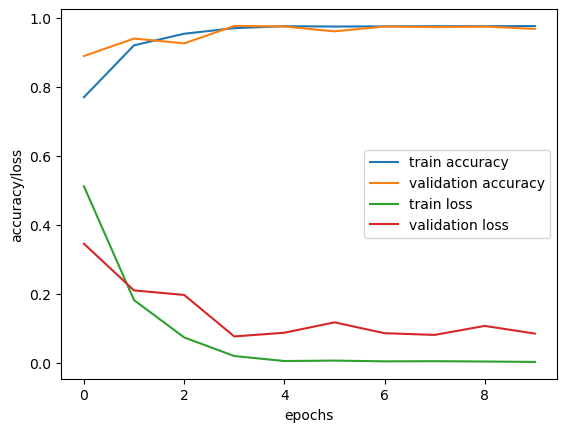

In [72]:
plot_result(train_accs, valid_accs, train_losses, valid_losses)

Below shows the confusion matrix for the prediction on training data.

Text(50.58159722222221, 0.5, 'Actual')

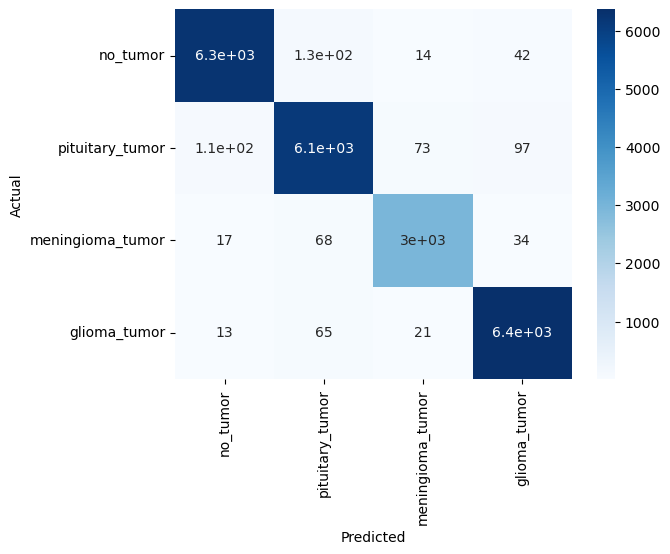

In [75]:
classes_ = ["no_tumor", "pituitary_tumor", "meningioma_tumor", "glioma_tumor"]
sns.heatmap(train_tot_cm, annot=True, cmap='Blues', xticklabels=classes_, yticklabels=classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [81]:
36/5470

0.006581352833638025

Below shows the confusion matrix on validation data. We see that the model is predicting very well overall. 61 pituitary tumor images are classified incorrectly as glioma tumor and 52 no tumor images are misclassified as pitutary tumor. However, these only consists of 1.115% and 0.9506% of the whole data. Note that our priority is to reduce falsely predicting as having no tumor. In total, there are 27+4+5=36 images that are misclassified as having no tumor, when they actually have a tumor. We introduce a specific metric to take account of this.  

$$
TumorMisdclassifiedRatio = \frac{n(\hat y =no tumor | y=pituitary tumor)+n(\hat y =no tumor | y=meningioma tumor)+n(\hat y =no tumor | y=glioma tumor)}{N} 
$$
<br>where $N$ refers to the total number of images. For the predictions on validation dataset, our TumorMissclassifiedRatio is 36/5470 = 0.006581 i.e. 0.6581%.

Text(50.58159722222221, 0.5, 'Actual')

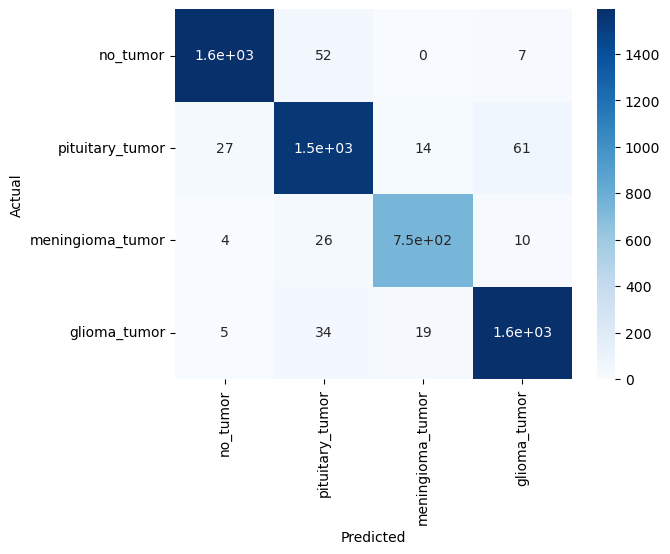

In [76]:
classes_ = ["no_tumor", "pituitary_tumor", "meningioma_tumor", "glioma_tumor"]
sns.heatmap(valid_tot_cm, annot=True, cmap='Blues', xticklabels=classes_, yticklabels=classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Prediction on Test Data

In [134]:
def create_test_loader(batch_size: int):
    # load imagefolder and apply transformers
    dataset = torchvision.datasets.ImageFolder(
        os.path.join(os.getcwd(), "../input/brain-tumor-classification-mri/Testing"),
        transform=get_transformer()
    )
    
    # creating data loader
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    return test_loader

In [180]:
test_loader = create_test_loader(64)

avg_loss, avg_acc, cm = valid_1epoch(model, test_loader, loss_func, device=device)
cm

100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


array([[ 21.,  51.,  27.,   1.],
       [  0., 112.,   3.,   0.],
       [  0.,   0., 105.,   0.],
       [  0.,   3.,  17.,  54.]])

# Tuning our Model

1. use momentum
2. tune initial lr, mometum, weight_decay
3. use different schedulers
4. data augmentation
5. ensembling
6. early-stopping

In [183]:
def new_transformer():
    return transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.1720, 0.1720, 0.1720], [0.1924, 0.1924, 0.1924])])

In [184]:
device = "cuda:0"
dryrun = False
batch_size = 128
num_epochs = 10

model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes
model.to(device)

train_loader, valid_loader = create_train_valid_data_loaders(batch_size, dryrun=dryrun, get_transformer=new_transformer)

# WE CHANGE THIS PART
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001
)
n_iterations = len(train_loader)*num_epochs
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iterations)
loss_func = torch.nn.CrossEntropyLoss()

train_cm, valid_cm, train_acc_list, _, valid_acc_list, _ = train(
    model,loss_func, optimizer, num_epochs, train_loader, valid_loader, device, dryrun)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 0 train


100%|██████████| 35/35 [00:32<00:00,  1.07it/s]


epoch 0 validation


100%|██████████| 9/9 [00:04<00:00,  2.07it/s]


epoch 1 train


100%|██████████| 35/35 [00:31<00:00,  1.10it/s]


epoch 1 validation


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


epoch 2 train


100%|██████████| 35/35 [00:32<00:00,  1.09it/s]


epoch 2 validation


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


epoch 3 train


100%|██████████| 35/35 [00:31<00:00,  1.10it/s]


epoch 3 validation


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


epoch 4 train


100%|██████████| 35/35 [00:31<00:00,  1.10it/s]


epoch 4 validation


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


epoch 5 train


100%|██████████| 35/35 [00:31<00:00,  1.09it/s]


epoch 5 validation


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


epoch 6 train


100%|██████████| 35/35 [00:32<00:00,  1.09it/s]


epoch 6 validation


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


epoch 7 train


100%|██████████| 35/35 [00:32<00:00,  1.09it/s]


epoch 7 validation


100%|██████████| 9/9 [00:04<00:00,  2.15it/s]


epoch 8 train


100%|██████████| 35/35 [00:32<00:00,  1.09it/s]


epoch 8 validation


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


epoch 9 train


100%|██████████| 35/35 [00:32<00:00,  1.09it/s]


epoch 9 validation


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


without weight decay

In [186]:
device = "cuda:0"
dryrun = False
batch_size = 128
num_epochs = 10

model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes
model.to(device)

train_loader, valid_loader = create_train_valid_data_loaders(batch_size, dryrun=dryrun, get_transformer=new_transformer)

# WE CHANGE THIS PART
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.9
)
n_iterations = len(train_loader)*num_epochs
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iterations)
loss_func = torch.nn.CrossEntropyLoss()

train_cm, valid_cm, train_acc_list, _, valid_acc_list, _ = train(
    model,loss_func, optimizer, num_epochs, train_loader, valid_loader, device, dryrun)

print(train_cm)
print(valid_cm)
print(train_acc_list)
print(valid_acc_list)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 0 train


100%|██████████| 17/17 [00:33<00:00,  1.95s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


epoch 1 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 2 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 2 validation


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


epoch 3 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 3 validation


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


epoch 4 train


100%|██████████| 17/17 [00:32<00:00,  1.90s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 5 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 5 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 6 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 6 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 7 train


100%|██████████| 17/17 [00:32<00:00,  1.90s/it]


epoch 7 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 8 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 8 validation


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


epoch 9 train


100%|██████████| 17/17 [00:33<00:00,  1.99s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

[[5702.  378.   41.  143.]
 [ 278. 5403.  209.  347.]
 [  48.  184. 2667.   79.]
 [  92.  262.   35. 5892.]]
[[1456.  164.   10.   20.]
 [  85. 1323.  103.  139.]
 [   7.   47.  727.    9.]
 [  26.  169.   24. 1431.]]
[tensor(0.5884, device='cuda:0'), tensor(0.8136, device='cuda:0'), tensor(0.8606, device='cuda:0'), tensor(0.8833, device='cuda:0'), tensor(0.8846, device='cuda:0'), tensor(0.8933, device='cuda:0'), tensor(0.8994, device='cuda:0'), tensor(0.9142, device='cuda:0'), tensor(0.9142, device='cuda:0'), tensor(0.9129, device='cuda:0')]
[tensor(0.8031, device='cuda:0'), tensor(0.6725, device='cuda:0'), tensor(0.8380, device='cuda:0'), tensor(0.8763, device='cuda:0'), tensor(0.8833, device='cuda:0'), tensor(0.9024, device='cuda:0'), tensor(0.8659, device='cuda:0'), tensor(0.9094, device='cuda:0'), tensor(0.9129, device='cuda:0'), tensor(0.9373, device='cuda:0')]


without scheduler

In [187]:
device = "cuda:0"
dryrun = False
batch_size = 128
num_epochs = 10

model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes
model.to(device)

train_loader, valid_loader = create_train_valid_data_loaders(batch_size, dryrun=dryrun, get_transformer=new_transformer)

# WE CHANGE THIS PART
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001
)
n_iterations = len(train_loader)*num_epochs
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iterations)
loss_func = torch.nn.CrossEntropyLoss()

train_cm, valid_cm, train_acc_list, _, valid_acc_list, _ = train(
    model,loss_func, optimizer, num_epochs, train_loader, valid_loader, device, dryrun)

print(train_cm)
print(valid_cm)
print(train_acc_list)
print(valid_acc_list)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 0 train


100%|██████████| 17/17 [00:33<00:00,  1.96s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


epoch 1 train


100%|██████████| 17/17 [00:33<00:00,  1.96s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 2 train


100%|██████████| 17/17 [00:33<00:00,  1.98s/it]


epoch 2 validation


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


epoch 3 train


100%|██████████| 17/17 [00:33<00:00,  1.95s/it]


epoch 3 validation


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


epoch 4 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


epoch 5 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 5 validation


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


epoch 6 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 6 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 7 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 7 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 8 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 8 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 9 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

[[5709.  434.   11.  103.]
 [ 376. 5387.  180.  301.]
 [  45.  179. 2655.   98.]
 [ 116.  271.   31. 5864.]]
[[1347.  241.   36.   26.]
 [  32. 1382.  148.   88.]
 [   2.   35.  749.    4.]
 [  27.  198.   63. 1362.]]
[tensor(0.6224, device='cuda:0'), tensor(0.8010, device='cuda:0'), tensor(0.8458, device='cuda:0'), tensor(0.8615, device='cuda:0'), tensor(0.8916, device='cuda:0'), tensor(0.8916, device='cuda:0'), tensor(0.9033, device='cuda:0'), tensor(0.9029, device='cuda:0'), tensor(0.9111, device='cuda:0'), tensor(0.9120, device='cuda:0')]
[tensor(0.6742, device='cuda:0'), tensor(0.6516, device='cuda:0'), tensor(0.8711, device='cuda:0'), tensor(0.8275, device='cuda:0'), tensor(0.8955, device='cuda:0'), tensor(0.8902, device='cuda:0'), tensor(0.8537, device='cuda:0'), tensor(0.9111, device='cuda:0'), tensor(0.9303, device='cuda:0'), tensor(0.9268, device='cuda:0')]


without transformer

In [188]:
device = "cuda:0"
dryrun = False
batch_size = 128
num_epochs = 10

model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes
model.to(device)

train_loader, valid_loader = create_train_valid_data_loaders(batch_size, dryrun=dryrun, get_transformer=get_transformer)

# WE CHANGE THIS PART
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001
)

loss_func = torch.nn.CrossEntropyLoss()

train_cm, valid_cm, train_acc_list, _, valid_acc_list, _ = train(
    model,loss_func, optimizer, num_epochs, train_loader, valid_loader, device, dryrun)

print(train_cm)
print(valid_cm)
print(train_acc_list)
print(valid_acc_list)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 0 train


100%|██████████| 17/17 [00:33<00:00,  2.00s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


epoch 1 train


100%|██████████| 17/17 [00:33<00:00,  1.99s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


epoch 2 train


100%|██████████| 17/17 [00:34<00:00,  2.00s/it]


epoch 2 validation


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


epoch 3 train


100%|██████████| 17/17 [00:33<00:00,  2.00s/it]


epoch 3 validation


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


epoch 4 train


100%|██████████| 17/17 [00:34<00:00,  2.01s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


epoch 5 train


100%|██████████| 17/17 [00:33<00:00,  2.00s/it]


epoch 5 validation


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


epoch 6 train


100%|██████████| 17/17 [00:33<00:00,  1.99s/it]


epoch 6 validation


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


epoch 7 train


100%|██████████| 17/17 [00:33<00:00,  1.98s/it]


epoch 7 validation


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


epoch 8 train


100%|██████████| 17/17 [00:34<00:00,  2.01s/it]


epoch 8 validation


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


epoch 9 train


100%|██████████| 17/17 [00:33<00:00,  1.98s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

[[6040.  160.   35.   32.]
 [ 100. 5925.   90.   95.]
 [  26.   79. 2836.   50.]
 [  34.   68.   23. 6167.]]
[[1.545e+03 9.800e+01 1.000e+00 6.000e+00]
 [3.200e+01 1.484e+03 7.600e+01 5.800e+01]
 [2.000e+00 2.300e+01 7.650e+02 0.000e+00]
 [1.300e+01 4.900e+01 7.400e+01 1.514e+03]]
[tensor(0.6707, device='cuda:0'), tensor(0.8946, device='cuda:0'), tensor(0.9360, device='cuda:0'), tensor(0.9451, device='cuda:0'), tensor(0.9473, device='cuda:0'), tensor(0.9477, device='cuda:0'), tensor(0.9477, device='cuda:0'), tensor(0.9477, device='cuda:0'), tensor(0.9477, device='cuda:0'), tensor(0.9477, device='cuda:0')]
[tensor(0.7439, device='cuda:0'), tensor(0.9007, device='cuda:0'), tensor(0.9425, device='cuda:0'), tensor(0.9477, device='cuda:0'), tensor(0.9373, device='cuda:0'), tensor(0.9582, device='cuda:0'), tensor(0.9530, device='cuda:0'), tensor(0.9530, device='cuda:0'), tensor(0.9547, device='cuda:0'), tensor(0.9564, device='cuda:0')]


Now, we will do cross validation to create several models.

In [115]:
def create_cv_folds(labels, num_folds=5, seed=123, dryrun=False):
    # y must be ndarray
    x = np.arange(len(labels))
    
    if dryrun:
        return StratifiedShuffleSplit(n_splits=2, train_size=50, test_size=25, random_state=seed).split(x, labels)
    
    return StratifiedShuffleSplit(n_splits=num_folds, train_size=0.8, random_state=seed).split(x, labels)

In [109]:
def create_cv_data_loaders(batch_size, dryrun=False):
    
    # loading data
    dataset = torchvision.datasets.ImageFolder(os.path.join(os.getcwd(), "../input/brain-tumor-classification-mri/Training"),
                                              transform=new_transformer())
    
    # splitting into train and valid dataset
    labels = dataset.targets
    
    data_loaders = []
    for train_indices, valid_indices in create_cv_folds(labels, dryrun=dryrun):
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        valid_dataset = torch.utils.data.Subset(dataset, valid_indices)

        # creating data loader
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  drop_last=not dryrun)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
        
        data_loaders.append((train_loader, valid_loader))
    
    return data_loaders

In [172]:
device = "cuda:0"
dryrun = False

# placeholders
models = []
train_cms = []
valid_cms = []
train_accs = []
valid_accs = []

num_folds = 5
num_epochs = 4


for train_loader, valid_loader in create_cv_data_loaders(batch_size, dryrun=dryrun):
    model = torchvision.models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes
    model.to(device)

    # WE CHANGE THIS PART
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001
    )
    n_iterations = len(train_loader)*num_epochs
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iterations)
    loss_func = torch.nn.CrossEntropyLoss()

    train_cm, valid_cm, train_acc_list, _, valid_acc_list, _ = train(
        model,loss_func, optimizer, num_epochs, train_loader, valid_loader, device, dryrun)
    
    # storing data
    models.append(model)
    train_cms.append(train_cm)
    valid_cms.append(valid_cm)
    train_accs.append(train_acc_list)
    valid_accs.append(valid_acc_list)

with open("tuned_models.pickle", "wb") as file:
    pickle.dump(models, file)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 0 train


100%|██████████| 17/17 [00:35<00:00,  2.10s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


epoch 1 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


epoch 2 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 2 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 3 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 3 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 4 train


100%|██████████| 17/17 [00:33<00:00,  1.95s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 5 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 5 validation


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


epoch 6 train


100%|██████████| 17/17 [00:32<00:00,  1.94s/it]


epoch 6 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 7 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 7 validation


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


epoch 8 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 8 validation


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch 9 train


100%|██████████| 17/17 [00:32<00:00,  1.94s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 0 train


100%|██████████| 17/17 [00:33<00:00,  1.94s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 1 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 2 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 2 validation


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


epoch 3 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 3 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 4 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 5 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 5 validation


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


epoch 6 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 6 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 7 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 7 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 8 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 8 validation


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


epoch 9 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 0 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch 1 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 2 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 2 validation


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch 3 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 3 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 4 train


100%|██████████| 17/17 [00:32<00:00,  1.94s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


epoch 5 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 5 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 6 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 6 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 7 train


100%|██████████| 17/17 [00:32<00:00,  1.94s/it]


epoch 7 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 8 train


100%|██████████| 17/17 [00:32<00:00,  1.91s/it]


epoch 8 validation


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


epoch 9 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch 0 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


epoch 1 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 2 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 2 validation


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch 3 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 3 validation


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


epoch 4 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch 5 train


100%|██████████| 17/17 [00:36<00:00,  2.17s/it]


epoch 5 validation


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


epoch 6 train


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


epoch 6 validation


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


epoch 7 train


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


epoch 7 validation


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


epoch 8 train


100%|██████████| 17/17 [00:44<00:00,  2.59s/it]


epoch 8 validation


100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


epoch 9 train


100%|██████████| 17/17 [00:38<00:00,  2.27s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch 0 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 0 validation


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


epoch 1 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 1 validation


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


epoch 2 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 2 validation


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


epoch 3 train


100%|██████████| 17/17 [00:32<00:00,  1.90s/it]


epoch 3 validation


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


epoch 4 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 4 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 5 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 5 validation


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


epoch 6 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 6 validation


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


epoch 7 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 7 validation


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


epoch 8 train


100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


epoch 8 validation


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch 9 train


100%|██████████| 17/17 [00:32<00:00,  1.93s/it]


epoch 9 validation


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


In [173]:
valid_accs

[[tensor(0.6760, device='cuda:0'),
  tensor(0.6951, device='cuda:0'),
  tensor(0.7718, device='cuda:0'),
  tensor(0.8780, device='cuda:0'),
  tensor(0.7927, device='cuda:0'),
  tensor(0.8868, device='cuda:0'),
  tensor(0.8937, device='cuda:0'),
  tensor(0.9094, device='cuda:0'),
  tensor(0.9042, device='cuda:0'),
  tensor(0.8798, device='cuda:0')],
 [tensor(0.5174, device='cuda:0'),
  tensor(0.6672, device='cuda:0'),
  tensor(0.7091, device='cuda:0'),
  tensor(0.7909, device='cuda:0'),
  tensor(0.8972, device='cuda:0'),
  tensor(0.8659, device='cuda:0'),
  tensor(0.9321, device='cuda:0'),
  tensor(0.8484, device='cuda:0'),
  tensor(0.8798, device='cuda:0'),
  tensor(0.9042, device='cuda:0')],
 [tensor(0.6063, device='cuda:0'),
  tensor(0.6916, device='cuda:0'),
  tensor(0.8188, device='cuda:0'),
  tensor(0.8589, device='cuda:0'),
  tensor(0.7631, device='cuda:0'),
  tensor(0.8885, device='cuda:0'),
  tensor(0.8833, device='cuda:0'),
  tensor(0.8955, device='cuda:0'),
  tensor(0.8868, d

# Checking metrics on Prediction data

In [167]:
def predict(model, data_loader, loss_func, dataset_length, device=None):
    total_acc, total_loss = 0, 0
    preds = np.zeros((dataset_length))
    
    model.eval()
    prev_idx = 0
    
    with torch.no_grad():
        for X, y in tqdm(data_loader):
            if device:
                X = X.to(device)
                y = y.to(device)
                
            out = model(X)
            _, pred = torch.max(out, 1)
            pred = pred.cpu().numpy()
            print(pred)
            preds[prev_idx:prev_idx+len(pred)] = pred
            prev_idx += len(pred)

    return preds

def majority_vote(predictions):
    num_samples = predictions.shape[1]
    ensemble_predictions = np.empty(num_samples, dtype=np.int32)
    
    for j in range(num_samples):
        sample_predictions = predictions[:, j]
        counts = np.bincount(sample_predictions)
        ensemble_predictions[j] = np.argmax(counts)
    
    return ensemble_predictions

In [168]:
test_loader = create_test_loader(32)
dataset_length = len(test_loader.dataset)
preds = np.zeros((len(models), dataset_length))


for i, model in enumerate(models):
    preds[i, :] = predict(model, test_loader, loss_func, dataset_length, device=device)

ensemble_predictions = majority_vote(preds.astype(np.int32))

cm = np.zeros((4,4))

# load labels again
prev_idx = 0
for _, y in test_loader:
    cm += calculate_cm(y.numpy(), ensemble_predictions[prev_idx:prev_idx+len(y)])
    prev_idx += len(y)

print(cm)

  8%|▊         | 1/13 [00:00<00:03,  3.48it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 15%|█▌        | 2/13 [00:00<00:03,  3.62it/s]

[1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 23%|██▎       | 3/13 [00:00<00:02,  3.64it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 31%|███       | 4/13 [00:01<00:02,  3.66it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 38%|███▊      | 5/13 [00:01<00:02,  3.87it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 54%|█████▍    | 7/13 [00:01<00:01,  4.32it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1]


 69%|██████▉   | 9/13 [00:02<00:00,  4.75it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 77%|███████▋  | 10/13 [00:02<00:00,  4.87it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 85%|████████▍ | 11/13 [00:02<00:00,  3.89it/s]

[1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 2 1 1 1 1 1 1 1]


100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


[1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


  8%|▊         | 1/13 [00:00<00:02,  4.08it/s]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 1 2 2 2 2 2]


 15%|█▌        | 2/13 [00:00<00:02,  4.19it/s]

[1 1 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 1 1 2]


 23%|██▎       | 3/13 [00:00<00:02,  4.08it/s]

[1 0 1 2 1 1 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


 31%|███       | 4/13 [00:00<00:02,  4.04it/s]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1]


 38%|███▊      | 5/13 [00:01<00:01,  4.11it/s]

[1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2]


 54%|█████▍    | 7/13 [00:01<00:01,  4.47it/s]

[2 2 2 1 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 2 1 2 2 2 2 2 1 1 2 2 2 2]
[1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2]


 69%|██████▉   | 9/13 [00:02<00:00,  4.85it/s]

[2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2]


 77%|███████▋  | 10/13 [00:02<00:00,  4.96it/s]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


 85%|████████▍ | 11/13 [00:02<00:00,  3.97it/s]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2]


100%|██████████| 13/13 [00:03<00:00,  4.30it/s]


[1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]


  8%|▊         | 1/13 [00:00<00:03,  3.89it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2]


 15%|█▌        | 2/13 [00:00<00:02,  4.03it/s]

[1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]


 23%|██▎       | 3/13 [00:00<00:02,  3.62it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 31%|███       | 4/13 [00:01<00:02,  3.80it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 38%|███▊      | 5/13 [00:01<00:02,  4.00it/s]

[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


 54%|█████▍    | 7/13 [00:01<00:01,  4.40it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1]


 69%|██████▉   | 9/13 [00:02<00:00,  4.80it/s]

[1 2 2 2 2 1 1 1 1 1 2 2 2 1 2 1 1 1 2 2 2 1 1 1 2 2 1 1 1 2 1 2]
[2 2 2 2 1 1 1 2 1 1 2 2 2 1 2 1 1 1 2 1 2 2 2 1 1 1 1 2 2 1 2 2]


 77%|███████▋  | 10/13 [00:02<00:00,  4.86it/s]

[2 1 1 2 1 1 1 2 1 2 2 1 1 1 2 1 1 1 2 2 2 1 2 2 1 1 1 2 2 2 2 1]


 85%|████████▍ | 11/13 [00:02<00:00,  3.88it/s]

[1 1 1 1 1 2 2 1 2 2 1 1 1 1 1 2 1 2 1 1 1 1 2 2 2 1 1 1 1 1 1 1]


100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


[1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


  8%|▊         | 1/13 [00:00<00:02,  4.14it/s]

[1 2 1 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 1 2 2]


 15%|█▌        | 2/13 [00:00<00:02,  4.22it/s]

[1 1 1 1 2 2 1 1 1 2 2 1 2 1 2 2 1 2 2 2 2 1 2 1 1 1 2 1 2 1 1 1]


 23%|██▎       | 3/13 [00:00<00:02,  4.05it/s]

[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 1 2 2 2 2 2]


 31%|███       | 4/13 [00:00<00:02,  4.08it/s]

[2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 1 2 1 1 2 2 1 1 1]


 38%|███▊      | 5/13 [00:01<00:01,  4.19it/s]

[1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 2 1 2 1 1]


 46%|████▌     | 6/13 [00:01<00:01,  4.24it/s]

[1 2 2 1 2 2 1 2 1 2 2 2 1 2 2 1 1 1 2 1 1 2 2 2 2 1 1 1 1 1 2 2]


 62%|██████▏   | 8/13 [00:01<00:01,  4.63it/s]

[1 2 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2]
[2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2]


 77%|███████▋  | 10/13 [00:02<00:00,  4.88it/s]

[2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2]
[2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1]


 85%|████████▍ | 11/13 [00:02<00:00,  3.91it/s]

[2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2]


100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


[1 1 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 1 2 2 2 1 1 1 1 2 2 1 1 1]
[1 1 2 2 2 2 2 2 2 2]


  8%|▊         | 1/13 [00:00<00:03,  3.85it/s]

[1 1 2 1 1 1 2 2 2 2 2 1 1 2 1 1 2 2 2 1 2 2 2 1 2 2 1 1 2 1 1 2]


 15%|█▌        | 2/13 [00:00<00:02,  4.09it/s]

[2 1 1 1 2 2 2 1 2 2 1 1 1 2 2 2 2 2 1 2 2 1 2 1 1 1 1 1 1 2 2 0]


 23%|██▎       | 3/13 [00:00<00:02,  4.08it/s]

[0 0 0 1 0 0 0 2 1 1 1 2 2 2 1 2 1 1 1 2 2 2 1 2 1 1 1 1 1 2 2 1]


 31%|███       | 4/13 [00:00<00:02,  4.10it/s]

[1 2 2 1 2 2 1 1 2 1 1 2 2 1 1 1 2 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1]


 38%|███▊      | 5/13 [00:01<00:01,  4.24it/s]

[1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 2 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1]


 54%|█████▍    | 7/13 [00:01<00:01,  4.54it/s]

[1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1]


 69%|██████▉   | 9/13 [00:02<00:00,  4.85it/s]

[2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 1 2 2]
[2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2]


 77%|███████▋  | 10/13 [00:02<00:00,  4.91it/s]

[2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]


 85%|████████▍ | 11/13 [00:02<00:00,  3.94it/s]

[2 2 2 1 1 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 1]


100%|██████████| 13/13 [00:03<00:00,  4.28it/s]

[1 1 2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 2 2 2]
[2 2 1 1 1 1 1 1 2 1]


[[ 0. 67. 33.  0.]
 [ 0. 94. 21.  0.]
 [ 0. 15. 90.  0.]
 [ 0. 44. 30.  0.]]


In [170]:
preds

array([[1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 2., ..., 2., 2., 2.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 2., 1., ..., 2., 2., 2.],
       [1., 1., 2., ..., 1., 2., 1.]])

In [143]:
len(test_loader.dataset)

394

In [150]:
import numpy as np

# Create a float array
float_array = np.array([1.2, 2.7, 3.5, 4.9])

# Convert the float array to an int array
int_array = float_array.astype(int)

print(int_array)

[1 2 3 4]


In [169]:
test_loader = create_test_loader(32)
lst = []
for _, y in test_loader:
    lst.append(y)

print(lst)

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2]), tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2]), tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       